In [9]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('stations_data.csv', sep=',')
def map_to_five(x):
    return min(x, 5)
df['rounded_last_update_5mins'] = pd.to_datetime(df['rounded_last_update_5mins'])
df['time_as_fraction'] = df['rounded_last_update_5mins'].dt.hour * 3600 + df['rounded_last_update_5mins'].dt.minute * 60 + df['rounded_last_update_5mins'].dt.second
weekday=df['rounded_last_update_5mins'].dt.dayofweek
weekdaydf = pd.get_dummies(weekday, prefix='day_of_week')
df = pd.concat([df, weekdaydf], axis=1)



In [2]:

# Step 2: Convert these seconds to a fraction of the day
df['time_as_fraction'] = df['time_as_fraction'] / 86400
# Applying the function to the 'available_bike_stands' column
#y_set = pd.DataFrame(df['available_bike_stands'].apply(map_to_five))
y_set = df['available_bike_stands']
y_set =  pd.DataFrame(y_set)
# Ensure x_set is in the correct shape
x_set = df[['number','time_as_fraction','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4','day_of_week_5','day_of_week_6','temp','feels_like']]
#x_set =df.select_dtypes(include=['number'])
print(df.columns)
#x_set = df[['number','time_as_fraction','temp','feels_like']]
#x_set = df.drop(['available_bike_stands',"name","weather_desc","weather_brief",], axis=1)



# For the remainder dataset, separate X and Y as you did initially


Index(['number', 'name', 'position_lat', 'position_lng', 'available_bikes',
       'available_bike_stands', 'rounded_last_update',
       'rounded_last_update_5mins', 'temp', 'feels_like', 'humidity',
       'rain_1h', 'weather_desc', 'weather_brief', 'wind_speed', 'weatherid',
       'time_as_fraction', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')


In [3]:
station_number = x_set['number'].unique()
print(station_number)
x_set.columns

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  71  72  73  74
  75  76  77  78  79  80  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117]


Index(['number', 'time_as_fraction', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'temp', 'feels_like'],
      dtype='object')

In [4]:
print(y_set)

        available_bike_stands
0                          30
1                          30
2                          30
3                          29
4                          29
...                       ...
622716                     40
622717                     40
622718                     40
622719                     40
622720                     40

[622721 rows x 1 columns]


In [5]:
model_accuracies = []



Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0599 - categorical_accuracy: 0.0599 - loss: 3.7439 - mse: 0.0243
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0892 - categorical_accuracy: 0.0892 - loss: 3.4329 - mse: 0.0236
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0957 - categorical_accuracy: 0.0957 - loss: 3.4166 - mse: 0.0235
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1019 - categorical_accuracy: 0.1019 - loss: 3.3945 - mse: 0.0235
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0965 - categorical_accuracy: 0.0965 - loss: 3.4062 - mse: 0.0235
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1045 - categorical_accuracy: 0.1045 - loss: 3.3982 - mse: 0.0235
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0982 - categorical_accuracy: 0.0982 - loss: 3.3962 - mse: 0.0235
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0944 - categorical_accuracy: 0.0944 -

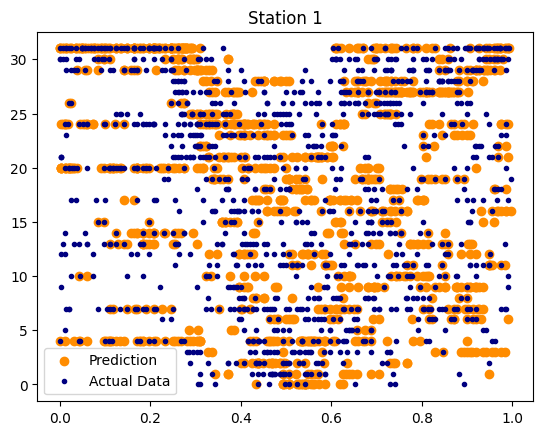


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1677 - categorical_accuracy: 0.1677 - loss: 4.1114 - mse: 0.0238        
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1929 - categorical_accuracy: 0.1929 - loss: 2.7118 - mse: 0.0223
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2062 - categorical_accuracy: 0.2062 - loss: 2.6797 - mse: 0.0222
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2112 - categorical_accuracy: 0.2112 - loss: 2.6732 - mse: 0.0222
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2042 - categorical_accuracy: 0.2042 - loss: 2.6842 - mse: 0.0222
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2086 - categorical_accuracy: 0.2086 - loss: 2.6606 - mse: 0.0222
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2046 - categorical_accuracy: 0.2046 - loss: 2.6632 - mse: 0.0222
Epoch 8/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2118 - categorical_accuracy: 

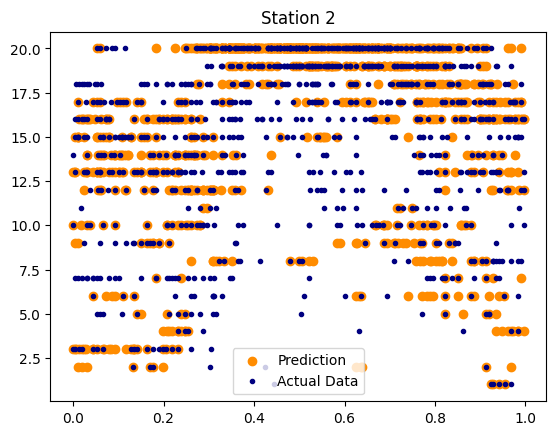


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0591 - categorical_accuracy: 0.0591 - loss: 3.9475 - mse: 0.0246
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0660 - categorical_accuracy: 0.0660 - loss: 3.0435 - mse: 0.0232
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0590 - categorical_accuracy: 0.0590 - loss: 3.0344 - mse: 0.0232
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0617 - categorical_accuracy: 0.0617 - loss: 3.0399 - mse: 0.0232
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0605 - categorical_accuracy: 0.0605 - loss: 3.0112 - mse: 0.0232
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0751 - categorical_accuracy: 0.0751 - loss: 3.0159 - mse: 0.0232
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0735 - categorical_accuracy: 0.0735 - loss: 3.0175 - mse: 0.0232
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0726 - categorical_accuracy: 0.0726 -

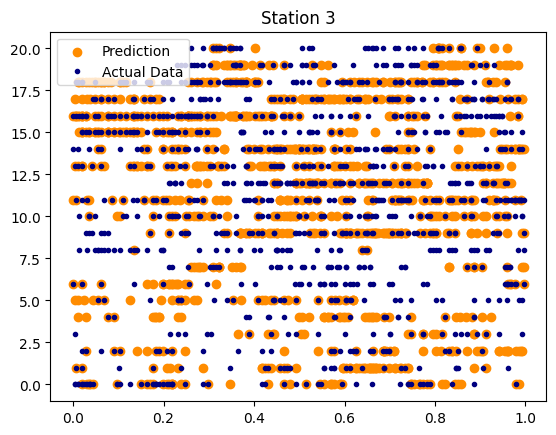


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0542 - categorical_accuracy: 0.0542 - loss: 4.1500 - mse: 0.0244
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0748 - categorical_accuracy: 0.0748 - loss: 3.0244 - mse: 0.0232
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0787 - categorical_accuracy: 0.0787 - loss: 3.0080 - mse: 0.0231        
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0803 - categorical_accuracy: 0.0803 - loss: 3.0019 - mse: 0.0231
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0788 - categorical_accuracy: 0.0788 - loss: 2.9915 - mse: 0.0231
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0786 - categorical_accuracy: 0.0786 - loss: 2.9965 - mse: 0.0231
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0860 - categorical_accuracy: 0.0860 - loss: 2.9817 - mse: 0.0231
Epoch 8/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0901 - categorical_accuracy: 

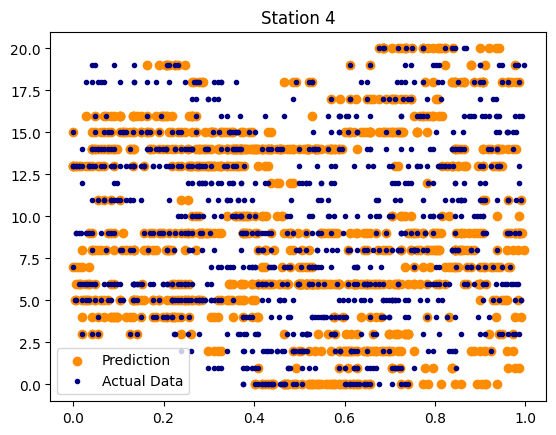


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0789 - categorical_accuracy: 0.0789 - loss: 3.9273 - mse: 0.0243
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0998 - categorical_accuracy: 0.0998 - loss: 3.5600 - mse: 0.0236
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0943 - categorical_accuracy: 0.0943 - loss: 3.5615 - mse: 0.0236
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0996 - categorical_accuracy: 0.0996 - loss: 3.5474 - mse: 0.0235
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0936 - categorical_accuracy: 0.0936 - loss: 3.5597 - mse: 0.0236
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0955 - categorical_accuracy: 0.0955 - loss: 3.5598 - mse: 0.0236
Epoch 7/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1069 - categorical_accuracy: 0.1069 - loss: 3.5286 - mse: 0.0235
Epoch 8/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1013 - categorical_ac

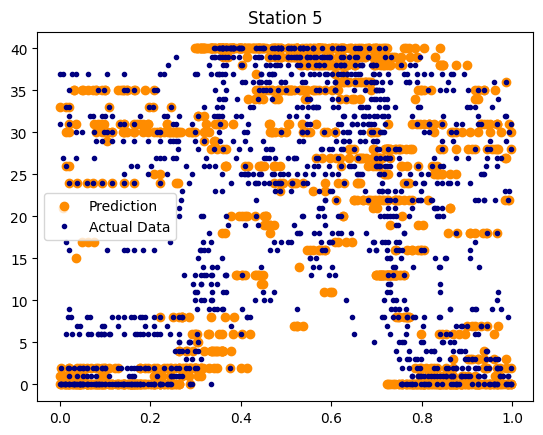


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1241 - categorical_accuracy: 0.1241 - loss: 4.1898 - mse: 0.0245        
Epoch 2/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1524 - categorical_accuracy: 0.1524 - loss: 2.6802 - mse: 0.0223
Epoch 3/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1419 - categorical_accuracy: 0.1419 - loss: 2.6788 - mse: 0.0223
Epoch 4/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1402 - categorical_accuracy: 0.1402 - loss: 2.6758 - mse: 0.0223
Epoch 5/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1487 - categorical_accuracy: 0.1487 - loss: 2.6506 - mse: 0.0222
Epoch 6/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1443 - categorical_accuracy: 0.1443 - loss: 2.6593 - mse: 0.0223
Epoch 7/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1638 - categorical_accuracy: 0.1638 - loss: 2.6347 - mse: 0.0221
Epoch 8/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1504 - categorical_accuracy: 

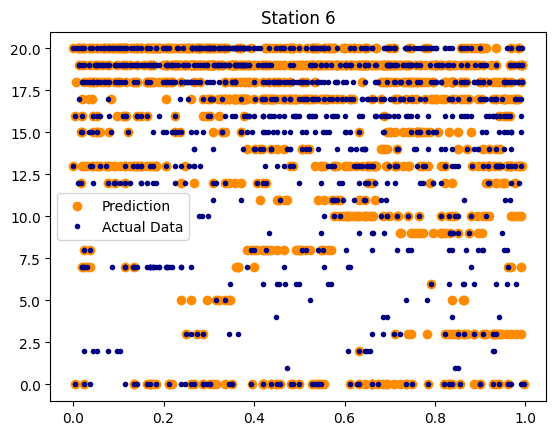


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0838 - categorical_accuracy: 0.0838 - loss: 3.9716 - mse: 0.0243
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0969 - categorical_accuracy: 0.0969 - loss: 3.1244 - mse: 0.0231
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0981 - categorical_accuracy: 0.0981 - loss: 3.1299 - mse: 0.0231
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1210 - categorical_accuracy: 0.1210 - loss: 3.1059 - mse: 0.0230
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1043 - categorical_accuracy: 0.1043 - loss: 3.0905 - mse: 0.0230
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1058 - categorical_accuracy: 0.1058 - loss: 3.1000 - mse: 0.0230
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1100 - categorical_accuracy: 0.1100 - loss: 3.1115 - mse: 0.0231
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1132 - categorical_accuracy: 0.1132 -

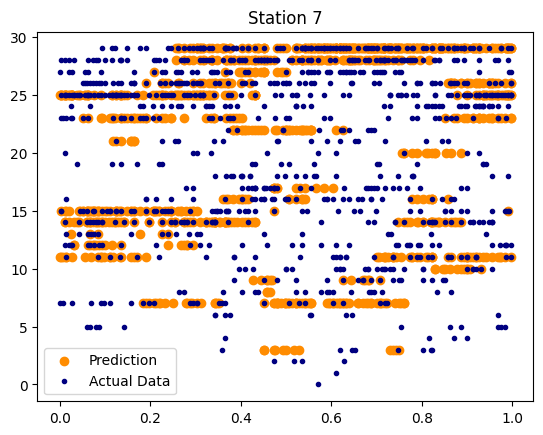


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0344 - categorical_accuracy: 0.0344 - loss: 3.8847 - mse: 0.0241
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0510 - categorical_accuracy: 0.0510 - loss: 3.4271 - mse: 0.0236
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0536 - categorical_accuracy: 0.0536 - loss: 3.4108 - mse: 0.0236
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0537 - categorical_accuracy: 0.0537 - loss: 3.4169 - mse: 0.0236
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0511 - categorical_accuracy: 0.0511 - loss: 3.4093 - mse: 0.0236
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0507 - categorical_accuracy: 0.0507 - loss: 3.4070 - mse: 0.0236
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0467 - categorical_accuracy: 0.0467 - loss: 3.4050 - mse: 0.0236
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0505 - categorical_accuracy: 0.0505 -

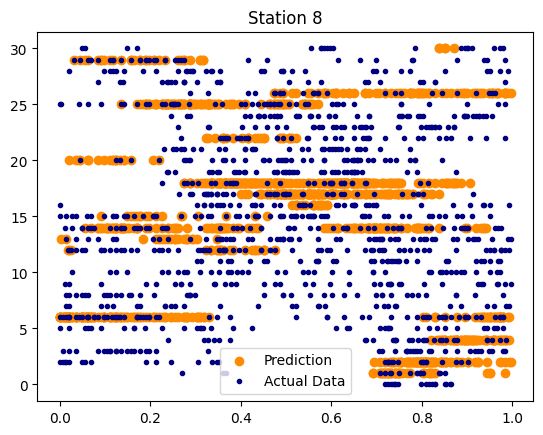


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0405 - categorical_accuracy: 0.0405 - loss: 4.4484 - mse: 0.0253        
Epoch 2/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0453 - categorical_accuracy: 0.0453 - loss: 3.2717 - mse: 0.0235
Epoch 3/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0471 - categorical_accuracy: 0.0471 - loss: 3.2498 - mse: 0.0235
Epoch 4/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0547 - categorical_accuracy: 0.0547 - loss: 3.2380 - mse: 0.0234
Epoch 5/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0534 - categorical_accuracy: 0.0534 - loss: 3.2224 - mse: 0.0234
Epoch 6/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0610 - categorical_accuracy: 0.0610 - loss: 3.2182 - mse: 0.0234
Epoch 7/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0527 - categorical_accuracy: 0.0527 - loss: 3.2168 - mse: 0.0234
Epoch 8/200
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0538 - catego

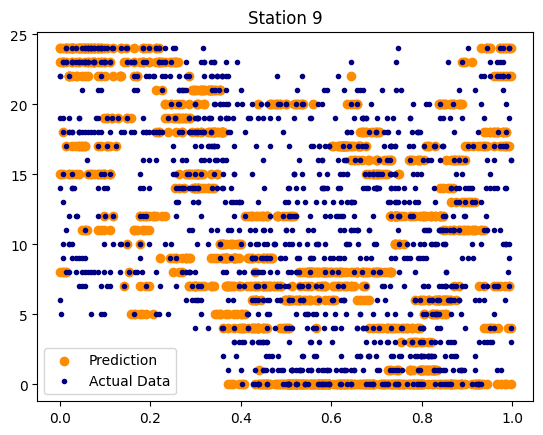


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1148 - categorical_accuracy: 0.1148 - loss: 3.6174 - mse: 0.0242       
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1712 - categorical_accuracy: 0.1712 - loss: 2.6787 - mse: 0.0224
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1534 - categorical_accuracy: 0.1534 - loss: 2.6768 - mse: 0.0225
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1642 - categorical_accuracy: 0.1642 - loss: 2.6435 - mse: 0.0224
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1605 - categorical_accuracy: 0.1605 - loss: 2.6601 - mse: 0.0224
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1686 - categorical_accuracy: 0.1686 - loss: 2.6434 - mse: 0.0224
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1665 - categorical_accuracy: 0.1665 - loss: 2.6530 - mse: 0.0224
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1662 - categorical_accuracy: 0

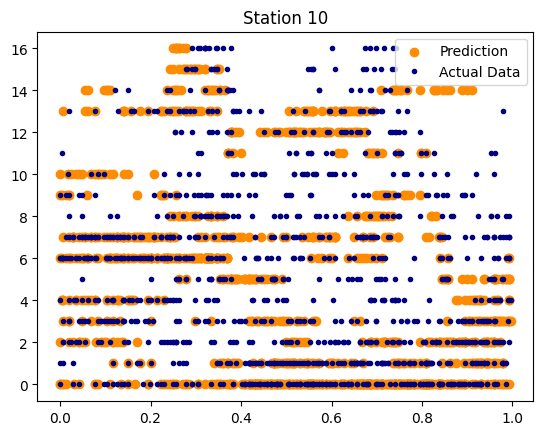


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1757 - categorical_accuracy: 0.1757 - loss: 3.8940 - mse: 0.0237         
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2185 - categorical_accuracy: 0.2185 - loss: 2.7329 - mse: 0.0219
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2336 - categorical_accuracy: 0.2336 - loss: 2.6972 - mse: 0.0218
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2155 - categorical_accuracy: 0.2155 - loss: 2.7016 - mse: 0.0218
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2143 - categorical_accuracy: 0.2143 - loss: 2.6773 - mse: 0.0218
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2207 - categorical_accuracy: 0.2207 - loss: 2.6795 - mse: 0.0218
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2244 - categorical_accuracy: 0.2244 - loss: 2.6553 - mse: 0.0217
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2260 - categorical_accuracy:

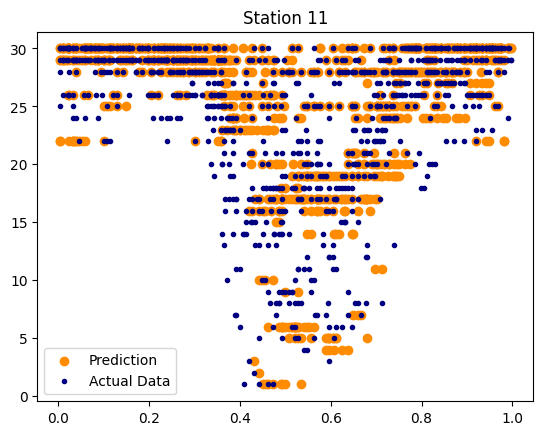


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0782 - categorical_accuracy: 0.0782 - loss: 3.9752 - mse: 0.0247         
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1260 - categorical_accuracy: 0.1260 - loss: 2.7469 - mse: 0.0226
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1216 - categorical_accuracy: 0.1216 - loss: 2.7152 - mse: 0.0225
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1140 - categorical_accuracy: 0.1140 - loss: 2.7374 - mse: 0.0226
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1273 - categorical_accuracy: 0.1273 - loss: 2.7009 - mse: 0.0225
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1312 - categorical_accuracy: 0.1312 - loss: 2.7006 - mse: 0.0225
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1197 - categorical_accuracy: 0.1197 - loss: 2.7050 - mse: 0.0225
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1386 - categorical_accuracy:

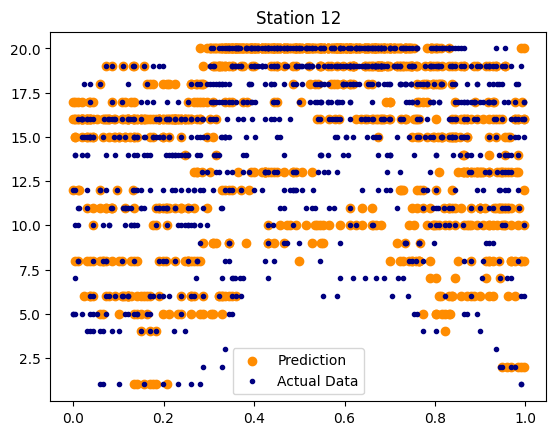


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1469 - categorical_accuracy: 0.1469 - loss: 4.8305 - mse: 0.0247        
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1984 - categorical_accuracy: 0.1984 - loss: 2.5924 - mse: 0.0218
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1745 - categorical_accuracy: 0.1745 - loss: 2.5609 - mse: 0.0218
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1770 - categorical_accuracy: 0.1770 - loss: 2.5736 - mse: 0.0219
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2164 - categorical_accuracy: 0.2164 - loss: 2.5660 - mse: 0.0218
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1815 - categorical_accuracy: 0.1815 - loss: 2.5960 - mse: 0.0219
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1951 - categorical_accuracy: 0.1951 - loss: 2.5740 - mse: 0.0218
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2103 - categorical_accuracy: 

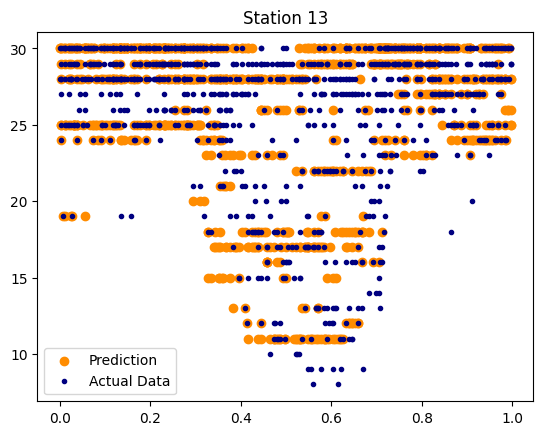


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0533 - categorical_accuracy: 0.0533 - loss: 4.1053 - mse: 0.0246
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0706 - categorical_accuracy: 0.0706 - loss: 3.3828 - mse: 0.0235
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0534 - categorical_accuracy: 0.0534 - loss: 3.3893 - mse: 0.0235
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0703 - categorical_accuracy: 0.0703 - loss: 3.3694 - mse: 0.0235
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0635 - categorical_accuracy: 0.0635 - loss: 3.3723 - mse: 0.0235
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0733 - categorical_accuracy: 0.0733 - loss: 3.3576 - mse: 0.0235
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0709 - categorical_accuracy: 0.0709 - loss: 3.3680 - mse: 0.0235
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0749 - categorical_accuracy: 0.0749 -

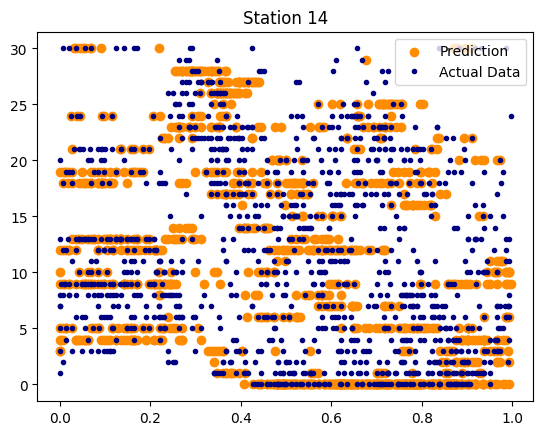


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1447 - categorical_accuracy: 0.1447 - loss: 3.0667 - mse: 0.0228
Epoch 2/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1537 - categorical_accuracy: 0.1537 - loss: 2.4543 - mse: 0.0219
Epoch 3/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1692 - categorical_accuracy: 0.1692 - loss: 2.4388 - mse: 0.0219
Epoch 4/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1686 - categorical_accuracy: 0.1686 - loss: 2.4259 - mse: 0.0218
Epoch 5/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1536 - categorical_accuracy: 0.1536 - loss: 2.4370 - mse: 0.0219
Epoch 6/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1578 - categorical_accuracy: 0.1578 - loss: 2.4332 - mse: 0.0219
Epoch 7/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1807 - categorical_accuracy: 0.1807 - loss: 2.4298 - mse: 0.0218
Epoch 8/200
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1751 - categorical_accuracy: 0.1751 -

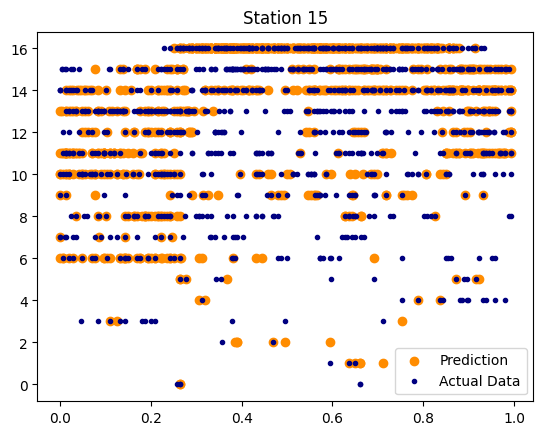


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1292 - categorical_accuracy: 0.1292 - loss: 3.6970 - mse: 0.0242       
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1649 - categorical_accuracy: 0.1649 - loss: 2.8530 - mse: 0.0227
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1789 - categorical_accuracy: 0.1789 - loss: 2.8098 - mse: 0.0226
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1822 - categorical_accuracy: 0.1822 - loss: 2.8023 - mse: 0.0225
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1687 - categorical_accuracy: 0.1687 - loss: 2.8147 - mse: 0.0226
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1756 - categorical_accuracy: 0.1756 - loss: 2.8159 - mse: 0.0226
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1739 - categorical_accuracy: 0.1739 - loss: 2.7937 - mse: 0.0226
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1693 - categorical_accuracy: 0

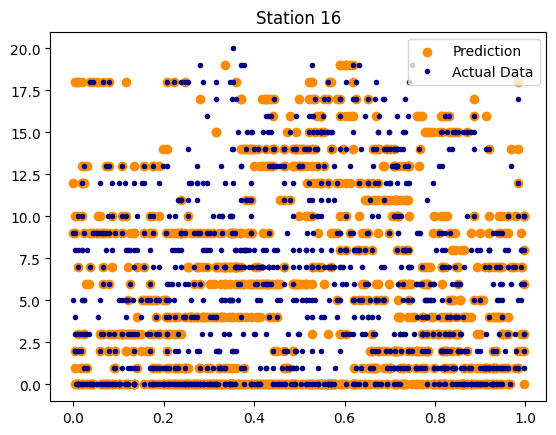


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1579 - categorical_accuracy: 0.1579 - loss: 3.5131 - mse: 0.0242         
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1944 - categorical_accuracy: 0.1944 - loss: 2.2773 - mse: 0.0213
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1913 - categorical_accuracy: 0.1913 - loss: 2.2561 - mse: 0.0212
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1872 - categorical_accuracy: 0.1872 - loss: 2.2317 - mse: 0.0212
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1900 - categorical_accuracy: 0.1900 - loss: 2.2351 - mse: 0.0212
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1994 - categorical_accuracy: 0.1994 - loss: 2.2710 - mse: 0.0213
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2019 - categorical_accuracy: 0.2019 - loss: 2.2379 - mse: 0.0212
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1968 - categorical_accuracy:

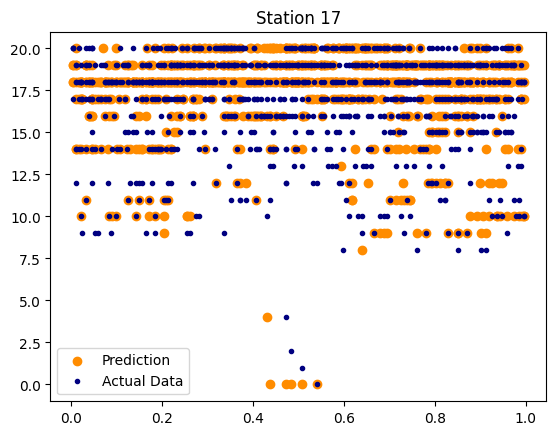


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0654 - categorical_accuracy: 0.0654 - loss: 4.3776 - mse: 0.0251
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0712 - categorical_accuracy: 0.0712 - loss: 3.1914 - mse: 0.0233
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0739 - categorical_accuracy: 0.0739 - loss: 3.1656 - mse: 0.0233
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0723 - categorical_accuracy: 0.0723 - loss: 3.1724 - mse: 0.0232
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0746 - categorical_accuracy: 0.0746 - loss: 3.1602 - mse: 0.0232
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0648 - categorical_accuracy: 0.0648 - loss: 3.1314 - mse: 0.0232
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0695 - categorical_accuracy: 0.0695 - loss: 3.1466 - mse: 0.0232
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0732 - categorical_accuracy: 0.0732 -

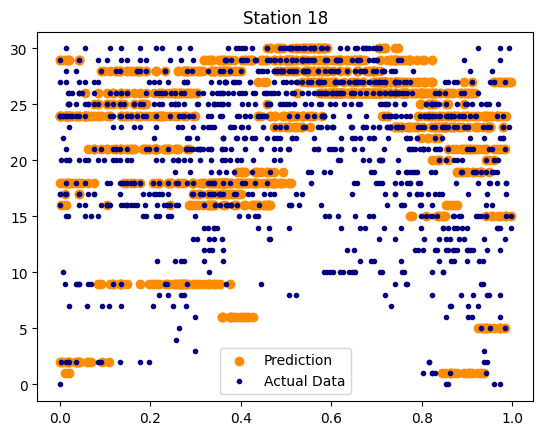


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1271 - categorical_accuracy: 0.1271 - loss: 4.0537 - mse: 0.0248
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1500 - categorical_accuracy: 0.1500 - loss: 3.2401 - mse: 0.0231
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1527 - categorical_accuracy: 0.1527 - loss: 3.1987 - mse: 0.0230
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1491 - categorical_accuracy: 0.1491 - loss: 3.2111 - mse: 0.0230
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1697 - categorical_accuracy: 0.1697 - loss: 3.1876 - mse: 0.0230
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1600 - categorical_accuracy: 0.1600 - loss: 3.2044 - mse: 0.0230
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1657 - categorical_accuracy: 0.1657 - loss: 3.1779 - mse: 0.0229
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1644 - categorical_ac

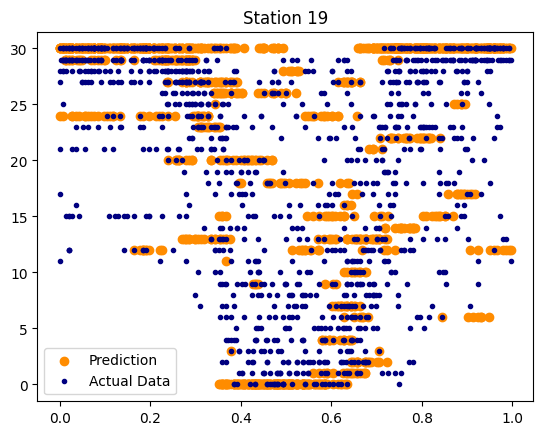


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2395 - categorical_accuracy: 0.2395 - loss: 4.0471 - mse: 0.0233
Epoch 2/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2628 - categorical_accuracy: 0.2628 - loss: 2.8846 - mse: 0.0219
Epoch 3/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2560 - categorical_accuracy: 0.2560 - loss: 2.8680 - mse: 0.0219
Epoch 4/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2723 - categorical_accuracy: 0.2723 - loss: 2.8551 - mse: 0.0219
Epoch 5/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2677 - categorical_accuracy: 0.2677 - loss: 2.8939 - mse: 0.0219
Epoch 6/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2722 - categorical_accuracy: 0.2722 - loss: 2.8403 - mse: 0.0218
Epoch 7/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2617 - categorical_accuracy: 0.2617 - loss: 2.8543 - mse: 0.0219
Epoch 8/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2660 - categorical_accuracy: 0.2660 -

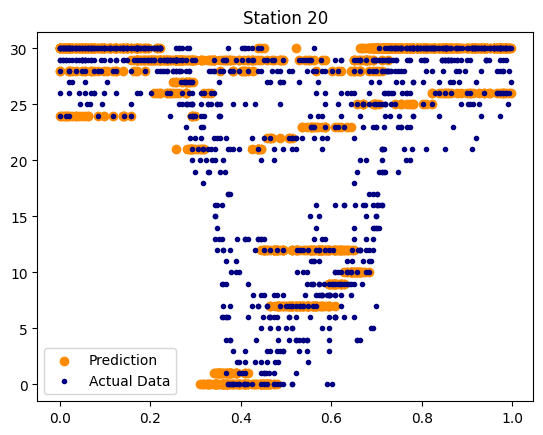


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0501 - categorical_accuracy: 0.0501 - loss: 4.0011 - mse: 0.0242
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0541 - categorical_accuracy: 0.0541 - loss: 3.4172 - mse: 0.0236
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0517 - categorical_accuracy: 0.0517 - loss: 3.4163 - mse: 0.0236
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0554 - categorical_accuracy: 0.0554 - loss: 3.4089 - mse: 0.0236
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0609 - categorical_accuracy: 0.0609 - loss: 3.3990 - mse: 0.0235
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0600 - categorical_accuracy: 0.0600 - loss: 3.4016 - mse: 0.0235
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0540 - categorical_accuracy: 0.0540 - loss: 3.3902 - mse: 0.0235
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0622 - categorical_accuracy: 0.0622 -

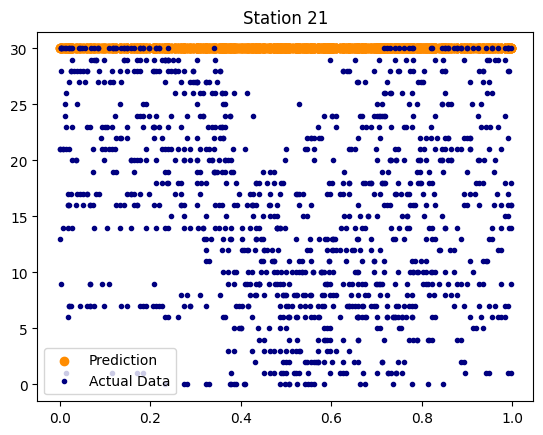


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0455 - categorical_accuracy: 0.0455 - loss: 5.1247 - mse: 0.0261        
Epoch 2/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0501 - categorical_accuracy: 0.0501 - loss: 3.0775 - mse: 0.0233
Epoch 3/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0497 - categorical_accuracy: 0.0497 - loss: 3.0803 - mse: 0.0233       
Epoch 4/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0446 - categorical_accuracy: 0.0446 - loss: 3.0662 - mse: 0.0233
Epoch 5/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0613 - categorical_accuracy: 0.0613 - loss: 3.0517 - mse: 0.0232
Epoch 6/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0560 - categorical_accuracy: 0.0560 - loss: 3.0502 - mse: 0.0232
Epoch 7/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0527 - categorical_accuracy: 0.0527 - loss: 3.0438 - mse: 0.0232
Epoch 8/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0554 - categorical_acc

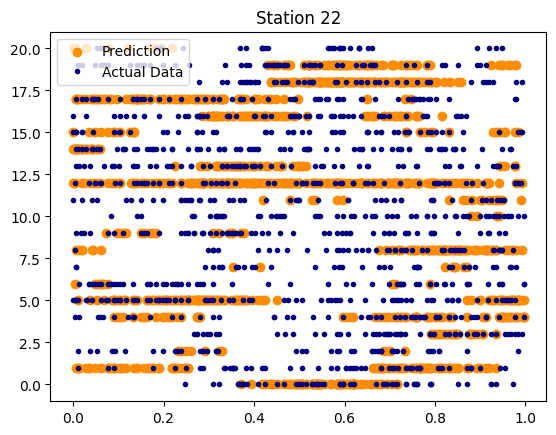


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1053 - categorical_accuracy: 0.1053 - loss: 5.5010 - mse: 0.0261
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1747 - categorical_accuracy: 0.1747 - loss: 3.1254 - mse: 0.0229
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1721 - categorical_accuracy: 0.1721 - loss: 3.1093 - mse: 0.0229
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1667 - categorical_accuracy: 0.1667 - loss: 3.1018 - mse: 0.0229
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1616 - categorical_accuracy: 0.1616 - loss: 3.1268 - mse: 0.0229
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1746 - categorical_accuracy: 0.1746 - loss: 3.1057 - mse: 0.0229
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1752 - categorical_accuracy: 0.1752 - loss: 3.0869 - mse: 0.0228
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1562 - categorical_accuracy: 0.1562 -

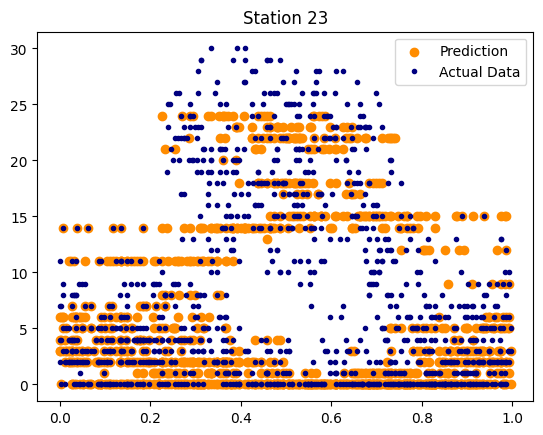


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0497 - categorical_accuracy: 0.0497 - loss: 4.0769 - mse: 0.0251        
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0589 - categorical_accuracy: 0.0589 - loss: 3.0700 - mse: 0.0233
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0597 - categorical_accuracy: 0.0597 - loss: 3.0492 - mse: 0.0232
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0642 - categorical_accuracy: 0.0642 - loss: 3.0430 - mse: 0.0232
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0745 - categorical_accuracy: 0.0745 - loss: 3.0327 - mse: 0.0232
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0626 - categorical_accuracy: 0.0626 - loss: 3.0248 - mse: 0.0232
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0712 - categorical_accuracy: 0.0712 - loss: 3.0217 - mse: 0.0232
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0650 - categorical_accuracy: 

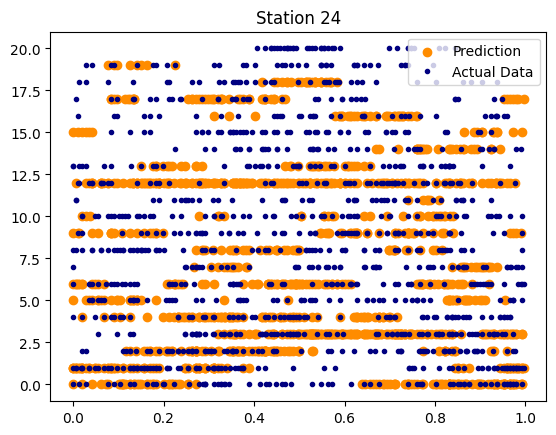


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1083 - categorical_accuracy: 0.1083 - loss: 4.0168 - mse: 0.0249
Epoch 2/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1317 - categorical_accuracy: 0.1317 - loss: 3.1278 - mse: 0.0230
Epoch 3/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1469 - categorical_accuracy: 0.1469 - loss: 3.0754 - mse: 0.0229
Epoch 4/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1355 - categorical_accuracy: 0.1355 - loss: 3.0765 - mse: 0.0229
Epoch 5/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1290 - categorical_accuracy: 0.1290 - loss: 3.0958 - mse: 0.0229
Epoch 6/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1327 - categorical_accuracy: 0.1327 - loss: 3.0960 - mse: 0.0230
Epoch 7/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1287 - categorical_accuracy: 0.1287 - loss: 3.0984 - mse: 0.0230
Epoch 8/200
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1422 - categorical_accuracy: 0.1422 -

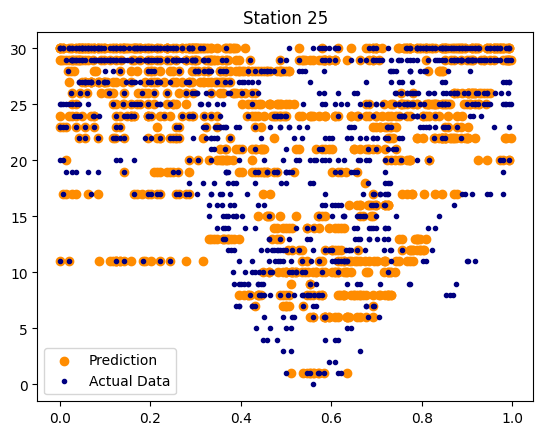


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0628 - categorical_accuracy: 0.0628 - loss: 4.0075 - mse: 0.0239
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0675 - categorical_accuracy: 0.0675 - loss: 3.0351 - mse: 0.0232       
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0675 - categorical_accuracy: 0.0675 - loss: 3.0254 - mse: 0.0232
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0732 - categorical_accuracy: 0.0732 - loss: 3.0107 - mse: 0.0231
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0744 - categorical_accuracy: 0.0744 - loss: 3.0059 - mse: 0.0231
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0772 - categorical_accuracy: 0.0772 - loss: 3.0033 - mse: 0.0231
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0732 - categorical_accuracy: 0.0732 - loss: 3.0129 - mse: 0.0232
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0784 - categorical_accuracy: 0

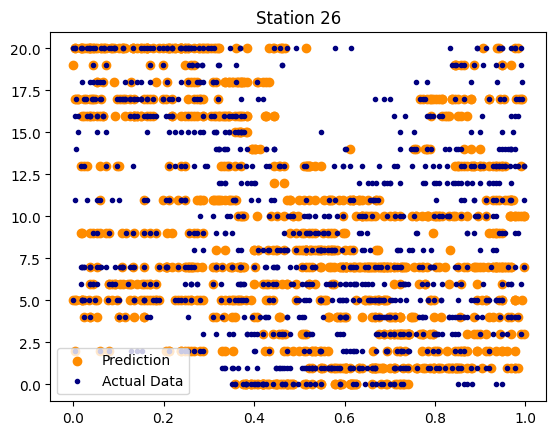


Epoch 1/200


c:\Users\thede\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0754 - categorical_accuracy: 0.0754 - loss: 3.9040 - mse: 0.0248       
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1076 - categorical_accuracy: 0.1076 - loss: 3.0316 - mse: 0.0231
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1008 - categorical_accuracy: 0.1008 - loss: 3.0168 - mse: 0.0231
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1172 - categorical_accuracy: 0.1172 - loss: 3.0053 - mse: 0.0231
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1056 - categorical_accuracy: 0.1056 - loss: 3.0146 - mse: 0.0231
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1110 - categorical_accuracy: 0.1110 - loss: 3.0059 - mse: 0.0231
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1123 - categorical_accuracy: 0.1123 - loss: 3.0024 - mse: 0.0231
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1200 - categorical_accuracy: 0

KeyboardInterrupt: 

In [11]:
for num in station_number:
    x_set_num = x_set.loc[x_set['number'] == num]
    y_set_num = y_set[x_set['number'] == num]
    x_set_num = x_set_num.drop('number', axis=1)
    
    y_set_num = to_categorical(y_set_num, num_classes=41)  # Ensure num_classes matches your model's output
    
    
    train_x = x_set_num.sample(frac=.8, replace=True)
    remainder_x = x_set_num.drop(train_x.index)
    y_set_num = pd.DataFrame(y_set_num)

    x_set_num.reset_index(drop=True, inplace=True)
    y_set_num.reset_index(drop=True, inplace=True)

    train_x = x_set_num.sample(frac=.8, replace=False)
    remainder_x = x_set_num.drop(train_x.index)

    y_train = y_set_num.iloc[train_x.index]
    remainder_y = y_set_num.iloc[remainder_x.index]
    print()
    model = tf.keras.Sequential([
        tf.keras.layers.Normalization(input_shape=[10,], axis=None),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(41, activation='softmax', use_bias=True)
    ])
    
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', 'mse', 'categorical_accuracy'])
    
    model.fit(train_x, y_train, epochs=200, batch_size=50)
    
    evaluation = model.evaluate(remainder_x, remainder_y, verbose=2)
    accuracy = evaluation[1]  # Assuming accuracy is the second metric
    model_accuracies.append(accuracy)
    print(f"Model evaluation on remainder set: {evaluation}")
    y_pred = model.predict(remainder_x)

    # Assuming y_pred is one-hot encoded, you might need to convert it to labels if y_test is not one-hot encoded
    # This step depends on the format of your y_test
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_numerical = np.argmax(remainder_y.to_numpy(), axis=1)

    # Plotting
    plt.figure()
    # Note: Adjust these x and y values according to your data structure and prediction results
    plt.scatter(remainder_x['time_as_fraction'], y_pred_labels, color="darkorange", label="Prediction")
    plt.plot(remainder_x['time_as_fraction'], y_test_numerical, 'o', color="navy", label="Actual Data", markersize=3)
    plt.axis("tight")
    plt.title(f"Station {num}")
    plt.legend()
    plt.show()


In [12]:
print(sum(model_accuracies)/len(model_accuracies))

0.2528237407519059


In [13]:
print(len(model_accuracies))

44
